<a href="https://colab.research.google.com/github/user292606/InsightCart/blob/main/ML_Models_for_InsightCart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product-based Capstone Project

# Team (C241-PS449) | InsightCart

## Install Packages and Libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import zipfile
import warnings
import math
from scipy.stats import variation
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

## Gathering Data

In [62]:
zip_file_path = "/content/archive.zip"
extracted_dir_path = "/content/archive"
os.makedirs(extracted_dir_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# List the extracted files
extracted_files = os.listdir(extracted_dir_path)
print("Extracted files:", extracted_files)

Extracted files: ['staff.csv', 'sales_outlet.csv', 'generations.csv', 'Dates.csv', 'pastry inventory.csv', 'product.csv', '201904 sales reciepts.csv', 'sales targets.csv', 'customer.csv']


In [64]:
# Show the 201904 sales reciepts data specifically
file_path = os.path.join(extracted_dir_path, "201904 sales reciepts.csv")
sr_df = pd.read_csv(file_path).drop(['transaction_id', 'line_item_id', 'customer_id', 'staff_id', 'line_item_amount'], axis=1)
print(sr_df.head())

  transaction_date transaction_time  sales_outlet_id instore_yn  order  \
0       2019-04-01         12:04:43                3          N      1   
1       2019-04-01         15:54:39                3          N      1   
2       2019-04-01         14:34:59                3          Y      1   
3       2019-04-01         16:06:04                3          N      1   
4       2019-04-01         19:18:37                3          Y      1   

   product_id  quantity  unit_price promo_item_yn  
0          52         1        2.50             N  
1          27         2        3.50             N  
2          46         2        2.50             N  
3          23         2        2.50             N  
4          34         1        2.45             N  


## Assessing Data

In [65]:
# Show the Information of the Data
sr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49894 entries, 0 to 49893
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_date  49894 non-null  object 
 1   transaction_time  49894 non-null  object 
 2   sales_outlet_id   49894 non-null  int64  
 3   instore_yn        49894 non-null  object 
 4   order             49894 non-null  int64  
 5   product_id        49894 non-null  int64  
 6   quantity          49894 non-null  int64  
 7   unit_price        49894 non-null  float64
 8   promo_item_yn     49894 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 3.4+ MB


In [66]:
#Make the data type for transaction date into date time
sr_df["transaction_date"] = sr_df["transaction_date"].apply(pd.to_datetime)

In [67]:
# Checking the information of the data
sr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49894 entries, 0 to 49893
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_date  49894 non-null  datetime64[ns]
 1   transaction_time  49894 non-null  object        
 2   sales_outlet_id   49894 non-null  int64         
 3   instore_yn        49894 non-null  object        
 4   order             49894 non-null  int64         
 5   product_id        49894 non-null  int64         
 6   quantity          49894 non-null  int64         
 7   unit_price        49894 non-null  float64       
 8   promo_item_yn     49894 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 3.4+ MB


In [68]:
# Assessing the Data Duplicates
print("The amount of data duplicates on sales receipt data is : ", sr_df.duplicated().sum())

The amount of data duplicates on sales receipt data is :  81


In [69]:
# Find columns with duplicated data
columns_with_duplicates = []
for column in sr_df.columns:
    if sr_df[column].duplicated().any():
        columns_with_duplicates.append(column)

print(columns_with_duplicates)

['transaction_date', 'transaction_time', 'sales_outlet_id', 'instore_yn', 'order', 'product_id', 'quantity', 'unit_price', 'promo_item_yn']


In [70]:
# Checking the Parameter (Descriptive Statistics)
sr_df.describe()

,transaction_date,sales_outlet_id,order,product_id,quantity,unit_price
count,49894,49894.000000,49894.000000,49894.000000,49894.000000,49894.000000
mean,2019-04-15 01:16:35.855213312,5.351846,1.173428,47.878983,1.438209,3.384645
min,2019-04-01 00:00:00,3.000000,1.000000,1.000000,1.000000,0.800000
25%,2019-04-08 00:00:00,3.000000,1.000000,33.000000,1.000000,2.500000
50%,2019-04-15 00:00:00,5.000000,1.000000,47.000000,1.000000,3.000000
75%,2019-04-22 00:00:00,8.000000,1.000000,60.000000,2.000000,3.750000
max,2019-04-29 00:00:00,8.000000,9.000000,87.000000,8.000000,45.000000
std,NaN,2.074796,1.025445,17.928355,0.543039,2.682545


In [71]:
#Checking on The Missing Value
sr_df.isnull().sum()

transaction_date    0
transaction_time    0
sales_outlet_id     0
instore_yn          0
order               0
product_id          0
quantity            0
unit_price          0
promo_item_yn       0
dtype: int64

In [72]:
# Separating the Category and Numeric Variables
columns = sr_df.columns
numeric = []
category = []

for elt in columns:
    if sr_df[elt].dtype == 'O':
        category.append(elt)
    else:
        numeric.append(elt)

print(f"Numeric : {numeric}  \n--> Size = {len(numeric)} numeric variable")
print(f"Category : {category}  \n---> Size = {len(category)} categorical variable")

Numeric : ['transaction_date', 'sales_outlet_id', 'order', 'product_id', 'quantity', 'unit_price']  
--> Size = 6 numeric variable
Category : ['transaction_time', 'instore_yn', 'promo_item_yn']  
---> Size = 3 categorical variable


In [73]:
sr_df[numeric].head()

,transaction_date,sales_outlet_id,order,product_id,quantity,unit_price
0,2019-04-01,3,1,52,1,2.50
1,2019-04-01,3,1,27,2,3.50
2,2019-04-01,3,1,46,2,2.50
3,2019-04-01,3,1,23,2,2.50
4,2019-04-01,3,1,34,1,2.45


In [74]:
# Show which outlet have the largest quantity of sales
sales_per_outlet = sr_df.groupby('sales_outlet_id')['quantity'].sum()
largest_sales_outlet = sales_per_outlet.idxmax()
print("Outlet with the largest sales based on quantity:", largest_sales_outlet)

Outlet with the largest sales based on quantity: 8


In [75]:
# Show which outlet have the smallest quantity of sales
sales_per_outlet = sr_df.groupby('sales_outlet_id')['quantity'].sum()
smallest_sales_outlet = sales_per_outlet.idxmin()
print("Outlet with the smallest sales based on quantity:", smallest_sales_outlet)

Outlet with the smallest sales based on quantity: 3


In [76]:
#Get the data from outlet 8 only
outlet_8_df = sr_df[sr_df['sales_outlet_id'] == 8]

print("DataFrame for sales outlet ID number 8:")
print(outlet_8_df)

DataFrame for sales outlet ID number 8:
      transaction_date transaction_time  sales_outlet_id instore_yn  order  \
1102        2019-04-01         09:05:11                8          Y      1   
1103        2019-04-01         10:38:16                8          Y      1   
1104        2019-04-01         10:38:16                8          Y      1   
1105        2019-04-01         08:57:46                8          N      1   
1106        2019-04-01         09:21:13                8          N      1   
...                ...              ...              ...        ...    ...   
49889       2019-04-29         16:51:58                8          N      1   
49890       2019-04-29         16:51:14                8          Y      1   
49891       2019-04-29         11:17:36                8          Y      1   
49892       2019-04-29         15:45:52                8          N      1   
49893       2019-04-29         15:45:52                8          N      1   

       product_id  quan

In [77]:
#Get the data from outlet 3 only
outlet_3_df = sr_df[sr_df['sales_outlet_id'] == 3]

print("DataFrame for sales outlet ID number 3:")
print(outlet_3_df)

DataFrame for sales outlet ID number 3:
      transaction_date transaction_time  sales_outlet_id instore_yn  order  \
0           2019-04-01         12:04:43                3          N      1   
1           2019-04-01         15:54:39                3          N      1   
2           2019-04-01         14:34:59                3          Y      1   
3           2019-04-01         16:06:04                3          N      1   
4           2019-04-01         19:18:37                3          Y      1   
...                ...              ...              ...        ...    ...   
49003       2019-04-29         18:11:08                3          Y      1   
49004       2019-04-29         15:49:24                3          Y      1   
49005       2019-04-29         14:56:16                3          Y      1   
49006       2019-04-29         14:56:16                3          Y      1   
49007       2019-04-29         12:14:16                3          Y      1   

       product_id  quan

In [78]:
outlet_3_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16829 entries, 0 to 49007
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_date  16829 non-null  datetime64[ns]
 1   transaction_time  16829 non-null  object        
 2   sales_outlet_id   16829 non-null  int64         
 3   instore_yn        16829 non-null  object        
 4   order             16829 non-null  int64         
 5   product_id        16829 non-null  int64         
 6   quantity          16829 non-null  int64         
 7   unit_price        16829 non-null  float64       
 8   promo_item_yn     16829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 1.3+ MB


In [79]:
outlet_8_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17071 entries, 1102 to 49893
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_date  17071 non-null  datetime64[ns]
 1   transaction_time  17071 non-null  object        
 2   sales_outlet_id   17071 non-null  int64         
 3   instore_yn        17071 non-null  object        
 4   order             17071 non-null  int64         
 5   product_id        17071 non-null  int64         
 6   quantity          17071 non-null  int64         
 7   unit_price        17071 non-null  float64       
 8   promo_item_yn     17071 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 1.3+ MB


In [80]:
sr_df[category].head()

,transaction_time,instore_yn,promo_item_yn
0,12:04:43,N,N
1,15:54:39,N,N
2,14:34:59,Y,N
3,16:06:04,N,N
4,19:18:37,Y,N


In [81]:
# Checking the Outliers
num_data = sr_df[numeric].drop('transaction_date', axis=1)  # Drop 'transaction_date' column once

def detect_outliers_iqr(num_data):
    Q1 = num_data.quantile(0.25)
    Q3 = num_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = {}
    for col in num_data.columns:
        col_outliers = num_data.index[(num_data[col] < lower_bound[col]) | (num_data[col] > upper_bound[col])]
        outliers_count[col] = len(col_outliers)

    return outliers_count

outliers_count = detect_outliers_iqr(num_data)
print("Number of outliers per column:")
for col, count in outliers_count.items():
    print(f"{col}: {count}")

Number of outliers per column:
sales_outlet_id: 0
order: 1507
product_id: 0
quantity: 14
unit_price: 1389


In [82]:
# Checking the Outliers for outlet 8 data
num_data8 = outlet_8_df[numeric].drop('transaction_date', axis=1)  # Drop 'transaction_date' column once

def detect_outliers_iqr(num_data):
    Q1 = num_data8.quantile(0.25)
    Q3 = num_data8.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = {}
    for col in num_data8.columns:
        col_outliers = num_data8.index[(num_data[col] < lower_bound[col]) | (num_data8[col] > upper_bound[col])]
        outliers_count[col] = len(col_outliers)

    return outliers_count

outliers_count = detect_outliers_iqr(num_data8)
print("Number of outliers per column on outlet 8 data:")
for col, count in outliers_count.items():
    print(f"{col}: {count}")

Number of outliers per column on outlet 8 data:
sales_outlet_id: 0
order: 509
product_id: 0
quantity: 4
unit_price: 501


In [83]:
filtered_df = outlet_8_df[~outlet_8_df['product_id'].between(69, 83)]

print(filtered_df)

      transaction_date transaction_time  sales_outlet_id instore_yn  order  \
1102        2019-04-01         09:05:11                8          Y      1   
1103        2019-04-01         10:38:16                8          Y      1   
1105        2019-04-01         08:57:46                8          N      1   
1106        2019-04-01         09:21:13                8          N      1   
1107        2019-04-01         08:12:03                8          Y      1   
...                ...              ...              ...        ...    ...   
49888       2019-04-29         16:36:24                8          N      1   
49889       2019-04-29         16:51:58                8          N      1   
49890       2019-04-29         16:51:14                8          Y      1   
49891       2019-04-29         11:17:36                8          Y      1   
49892       2019-04-29         15:45:52                8          N      1   

       product_id  quantity  unit_price promo_item_yn  
1102   

In [84]:
# Convert 'transaction_date' column to datetime
filtered_df['transaction_date'] = pd.to_datetime(filtered_df['transaction_date'])

# Group by date and sum the quantities
daily_sales = filtered_df.groupby(filtered_df['transaction_date'].dt.date)['quantity'].sum()

# Create a DataFrame with 29 days of data
start_date = daily_sales.index.min()
end_date = start_date + pd.Timedelta(days=28)
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize a DataFrame with 29 days and fill it with daily sales data
compiled_data = pd.DataFrame(index=date_range, columns=['quantity'])
compiled_data['quantity'] = daily_sales.reindex(date_range, fill_value=0)

# Reset index to have a column for date
compiled_data.reset_index(inplace=True)
compiled_data.rename(columns={'index': 'date'}, inplace=True)

print(compiled_data)

         date  quantity
0  2019-04-01       752
1  2019-04-02       744
2  2019-04-03       719
3  2019-04-04       703
4  2019-04-05       683
5  2019-04-06       704
6  2019-04-07       851
7  2019-04-08       793
8  2019-04-09       862
9  2019-04-10       802
10 2019-04-11       749
11 2019-04-12       816
12 2019-04-13       980
13 2019-04-14       814
14 2019-04-15       701
15 2019-04-16       732
16 2019-04-17       747
17 2019-04-18       777
18 2019-04-19       761
19 2019-04-20       754
20 2019-04-21       846
21 2019-04-22       596
22 2019-04-23       705
23 2019-04-24       671
24 2019-04-25       651
25 2019-04-26       629
26 2019-04-27       834
27 2019-04-28       586
28 2019-04-29       530


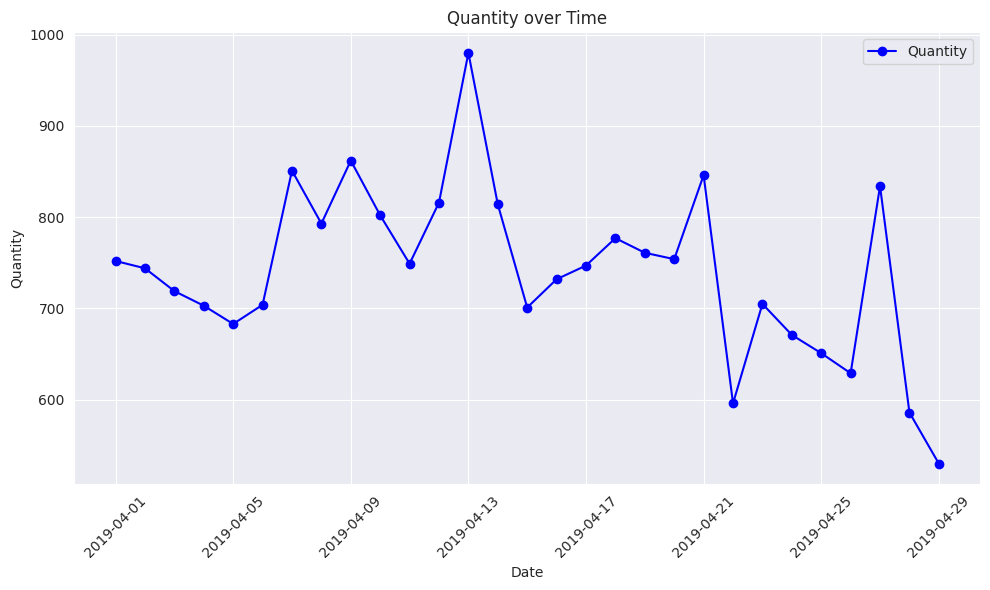

In [85]:
# Plotting the Time Series Data
plt.figure(figsize=(10, 6))
plt.plot(compiled_data['date'], compiled_data['quantity'], marker='o', linestyle='-', color='b', label='Quantity')
plt.title('Quantity over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

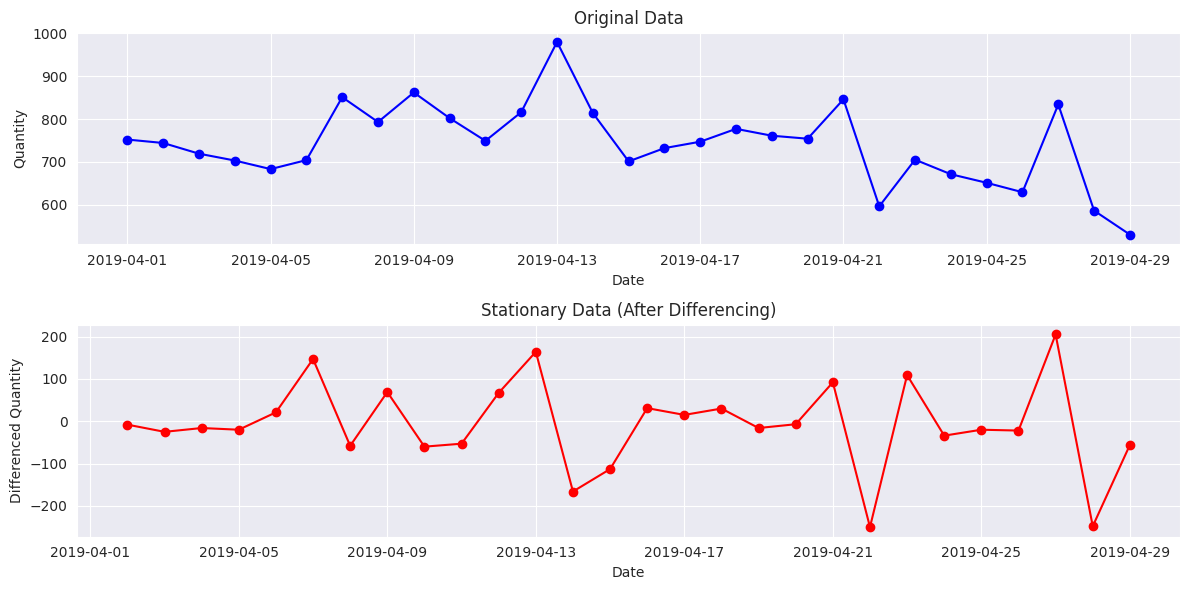

In [86]:
#### Make the time series data to be stationary with applying differencing and box-cox transformation
from scipy.stats import boxcox

# Calculate first differences
compiled_data['quantity_diff'] = compiled_data['quantity'].diff()

# Handle zero and negative values before applying Box-Cox
positive_quantity = compiled_data['quantity'][compiled_data['quantity'] > 0]

# Store the transformed data and lambda value in separate variables
quantity_boxcox, lambda_value = boxcox(positive_quantity)

# Create a new column in 'compiled_data' and fill it with the transformed values
compiled_data['quantity_boxcox'] = pd.Series(quantity_boxcox, index=positive_quantity.index)

# Plotting original and differenced data
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(compiled_data['date'], compiled_data['quantity'], marker='o', linestyle='-', color='b')
plt.title('Original Data')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(compiled_data['date'], compiled_data['quantity_diff'], marker='o', linestyle='-', color='r')
plt.title('Stationary Data (After Differencing)')
plt.xlabel('Date')
plt.ylabel('Differenced Quantity')
plt.grid(True)

plt.tight_layout()
plt.show()

In [87]:
#Calculate the Basic Statistics
mean_quantity = compiled_data['quantity'].mean()
median_quantity = compiled_data['quantity'].median()
std_quantity = compiled_data['quantity'].std()

print(f"Mean Quantity: {mean_quantity}")
print(f"Median Quantity: {median_quantity}")
print(f"Standard Deviation of Quantity: {std_quantity}")

Mean Quantity: 741.1034482758621
Median Quantity: 747.0
Standard Deviation of Quantity: 94.06735612147675


In [88]:
compiled_data.head()

,date,quantity,quantity_diff,quantity_boxcox
0,2019-04-01,752,NaN,561.879020
1,2019-04-02,744,-8.0,556.198693
2,2019-04-03,719,-25.0,538.427127
3,2019-04-04,703,-16.0,527.036599
4,2019-04-05,683,-20.0,512.779524


In [28]:
#Check the shape of the data
compiled_data.shape

(29, 4)

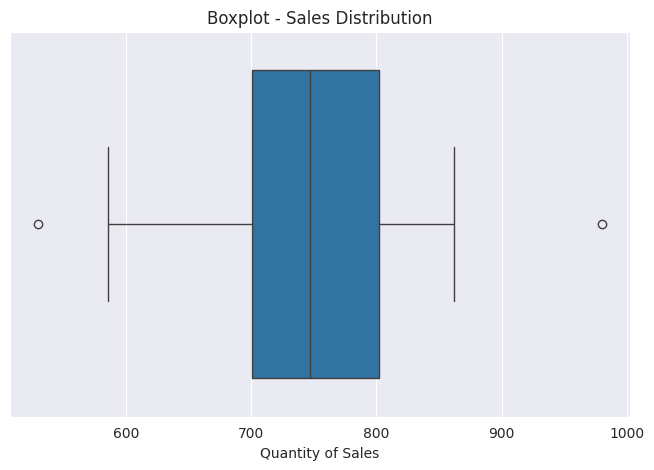

In [89]:
#Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=compiled_data, x='quantity')
plt.xlabel('Quantity of Sales')
plt.title(f'Boxplot - Sales Distribution');

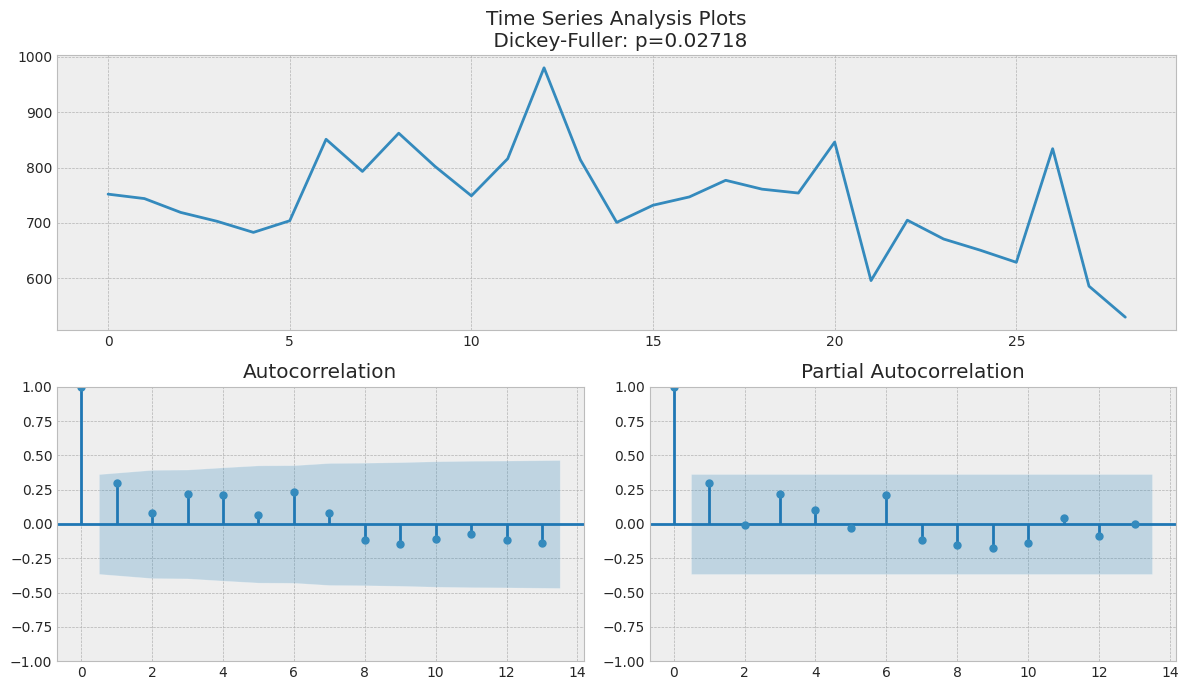

In [90]:
## Using ADF test to know if the time series data is already stationary or not
## Using ACF and PACF plot to help deciding the orders for the ARIMA

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as smt
import pandas as pd

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        if isinstance(y, pd.DataFrame) and y.shape[1] == 2:
            y = y.iloc[:, 1]
        else:
            raise ValueError("Input data should be a pandas Series or DataFrame with two columns.")

    with plt.style.context(style=style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))

        if lags is not None and len(y) >= lags:
            smt.plot_acf(y, lags=min(lags, len(y)-1), ax=acf_ax)
            smt.plot_pacf(y, lags=min(lags, len(y)-1), ax=pacf_ax)
        else:
            print("Input array length is less than the number of lags. Cannot plot autocorrelation.")

        plt.tight_layout()

tsplot(compiled_data['quantity'], lags=13)

In [91]:
## As for the ADF test resulting in p-value of 0.02718, it means that the p-value is less than the significance level of 0.05.
## Hence we can reject the null hypothesis and take that the series is stationary
## The ACF and PACF cuts off/not significant at lag 0 while its significant at lag 1 and others
## Significant spikes at higher lags (like lag 1 and beyond) indicate that these lags are contributing to the autocorrelation structure of the series.
## Significant spikes at higher lags in the PACF plot indicate that these lags are directly influencing the current value of the series.

## Data Preparation

In [93]:
# Splitting the data into training and testing sets
train_size = int(len(compiled_data) * 0.80)
train, test = compiled_data[:train_size], compiled_data[train_size:]
TIME_STEPS = 10
min_test_size = TIME_STEPS + 1
train_size = min(train_size, len(compiled_data) - min_test_size)
train, test = compiled_data[:train_size], compiled_data[train_size:]

# Scaling the data
scaler = StandardScaler()
train_quantity = train['quantity']
test_quantity = test['quantity']

train_scaled = scaler.fit_transform(train_quantity.values.reshape(-1, 1))
test_scaled = scaler.transform(test_quantity.values.reshape(-1, 1))

train_scaled_series = pd.Series(train_scaled.flatten(), index=train.index, name='sales_scaled')
test_scaled_series = pd.Series(test_scaled.flatten(), index=test.index, name='sales_scaled')

# Function to create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Create sequences with scaled data
X_train, y_train = create_sequences(train_scaled_series, train_scaled_series, TIME_STEPS)
X_test, y_test = create_sequences(test_scaled_series, test_scaled_series, TIME_STEPS)

# Reshape data
X_train = X_train.reshape(X_train.shape[0], TIME_STEPS, 1)
X_test = X_test.reshape(X_test.shape[0], TIME_STEPS, 1)

## Neural Networks

In [100]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    # Reshape data for StandardScaler (flatten along time steps)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Fit on training data
    scaler.fit(X_train_flat)

    # Transform training and test data
    X_train_scaled = scaler.transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)

    # Initialize neural network model
    model_nn = Sequential([
        Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(units=32, activation='relu'),
        Dense(units=1)
    ])

    # Compile the model
    model_nn.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model_nn.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

    # Predictions on the test set
    predictions_nn = model_nn.predict(X_test_scaled).flatten()

    # Calculate RMSE
    rmse_nn = np.sqrt(mean_squared_error(y_test, predictions_nn))
    print(f"Neural Network Test Set RMSE: {rmse_nn}")

    # Save the model to an HDF5 file
    model_nn.save("model_nn.h5")

    return model_nn, rmse_nn

if __name__ == '__main__':
    model, rmse = train_and_evaluate_model(X_train, X_test, y_train, y_test)
    print("Model saved successfully as model_nn.h5")

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 1.5690 - val_loss: 1.0095
Epoch 2/50
1/1 [==============================] - 0s 40ms/step - loss: 1.5438 - val_loss: 0.9508
Epoch 3/50
1/1 [==============================] - 0s 41ms/step - loss: 1.6649 - val_loss: 0.8928
Epoch 4/50
1/1 [==============================] - 0s 40ms/step - loss: 1.3107 - val_loss: 0.8471
Epoch 5/50
1/1 [==============================] - 0s 41ms/step - loss: 1.1695 - val_loss: 0.8007
Epoch 6/50
1/1 [==============================] - 0s 65ms/step - loss: 1.1582 - val_loss: 0.7482
Epoch 7/50
1/1 [==============================] - 0s 51ms/step - loss: 1.1380 - val_loss: 0.6972
Epoch 8/50
1/1 [==============================] - 0s 55ms/step - loss: 0.9205 - val_loss: 0.6581
Epoch 9/50
1/1 [==============================] - 0s 40ms/step - loss: 1.5215 - val_loss: 0.6329
Epoch 10/50
1/1 [==============================] - 0s 42ms/step - loss: 0.8422 - val_loss: 0.6102
Epoch 11/50
1/1 [==============

## ARIMA

In [101]:
!pip install pmdarima

In [102]:
import pmdarima as pm

autoarima_model = pm.auto_arima(compiled_data['quantity'], seasonal=True, m=7)
print(autoarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -170.824
Date:                Fri, 21 Jun 2024   AIC                            347.648
Time:                        09:00:10   BIC                            351.750
Sample:                             0   HQIC                           348.933
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    467.0721    136.595      3.419      0.001     199.351     734.793
ar.L1          0.3663      0.179      2.049      0.040       0.016       0.717
sigma2      7616.1623   1799.160      4.233      0.0

In [103]:
# The P-Value is 0.040 which is smaller value than the significance level 0.05
# It indicates that the model is significant statistically
# The coefficient for the AR(1) term (ar.L1) is 0.3663, indicating a positive autocorrelation at lag 1
# The residuals exhibit no significant autocorrelation at lag 1 (Ljung-Box (L1) (Q) p-value = 0.95)
# The residuals are normally distributed (Jarque-Bera (JB) p-value = 0.87), suggesting the model fits the data well in terms of distribution.
# Overall, this model provides a good fit to the data based on the statistical tests and diagnostics provided. Adjustments or further analysis may be necessary based on the specific requirements and characteristics of the time series data.

In [49]:
# Forecasting
n_periods = 7
forecast, conf_int = autoarima_model.predict(n_periods=n_periods, return_conf_int=True)

print("Forecasted values:")
print(forecast)

print("\nConfidence intervals:")
print(conf_int)

Forecasted values:
29    661.197716
30    709.252135
31    726.853259
32    733.300107
33    735.661425
34    736.526316
35    736.843104
dtype: float64

Confidence intervals:
[[490.15043085 832.2450017 ]
 [527.09221787 891.41205266]
 [543.25366453 910.45285265]
 [549.50822759 917.0919859 ]
 [551.84376455 919.47908514]
 [552.70519745 920.34743493]
 [553.02152139 920.66468682]]


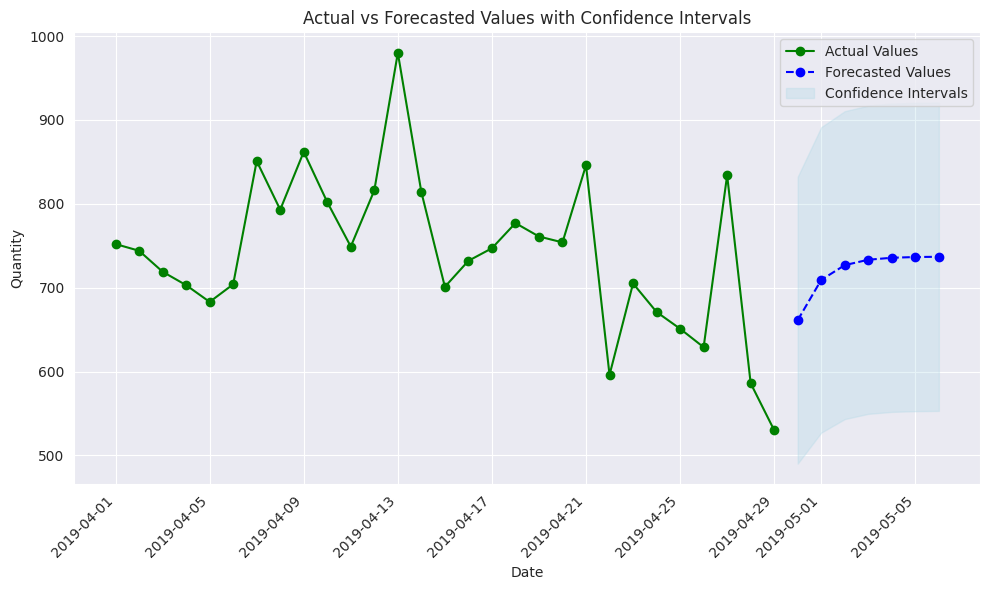

In [58]:
# Convert to DataFrame
compiled_data['date'] = pd.to_datetime(compiled_data['date'])

# Fit AutoARIMA
autoarima_model = pm.auto_arima(compiled_data['quantity'], seasonal=True, m=7)

# Forecasting
n_periods = 7
forecast, conf_int = autoarima_model.predict(n_periods=n_periods, return_conf_int=True)

# Generate forecast periods starting from the last date in 'compiled_data'
forecast_start_date = compiled_data['date'].max()
forecast_periods = pd.date_range(start=forecast_start_date, periods=n_periods + 1, freq='D')[1:]

# Example of actual data (replace with your actual values)
actual_values = compiled_data['quantity'].values[-n_periods:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(compiled_data['date'], compiled_data['quantity'], marker='o', color='green', linestyle='-', label='Actual Values')
plt.plot(forecast_periods, forecast, marker='o', color='blue', linestyle='--', label='Forecasted Values')
plt.fill_between(forecast_periods, conf_int[:, 0], conf_int[:, 1], color='lightblue', alpha=0.3, label='Confidence Intervals')
plt.title('Actual vs Forecasted Values with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)

# Adjust x-axis date labels to be slanted
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [50]:
# Evaluating the model
# Define function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

actual_values = compiled_data['quantity'].values[-n_periods:]

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_values, forecast)
print(f"MAPE: {mape:.2f}%")

# Calculate MSE
mse = mean_squared_error(actual_values, forecast)
print(f"MSE: {mse:.2f}")

MAPE: 16.66%
MSE: 13589.54


In [59]:
## The MAPE Value Indicates that, on average, the model's predictions are within approximately 16.66% of the actual values. For forecasting purposes, a MAPE of this magnitude suggests the model's predictions are reasonably accurate but could potentially be further improved.